# Lab 2: Cats vs Dogs

In this lab, you will train a convolutional neural network to classify an image
into one of two classes: "cat" or "dog". The code for the neural networks
you train will be written for you, and you are not (yet!) expected
to understand all provided code. However, by the end of the lab,
you should be able to:

1. Understand at a high level the training loop for a machine learning model.
2. Understand the distinction between training, validation, and test data.
3. The concepts of overfitting and underfitting.
4. Investigate how different hyperparameters, such as learning rate and batch size, affect the success of training.
5. Compare an ANN (aka Multi-Layer Perceptron) with a CNN.

### What to submit

Submit a PDF file containing all your code, outputs, and write-up
from parts 1-5. You can produce a PDF of your Google Colab file by
going to **File > Print** and then save as PDF. The Colab instructions
has more information.

**Do not submit any other files produced by your code.**

Include a link to your colab file in your submission.

Please use Google Colab to complete this assignment. If you want to use Jupyter Notebook, please complete the assignment and upload your Jupyter Notebook file to Google Colab for submission.

With Colab, you can export a PDF file using the menu option
`File -> Print` and save as PDF file. **Adjust the scaling to ensure that the text is not cutoff at the margins.**

## Colab Link

Include a link to your colab file here

Colab Link: https://colab.research.google.com/drive/1EVzNx6MKBSFb8FSn7MsRtSkGzd2loUQy?usp=sharing

In [1]:
import numpy as np
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torch.utils.data.sampler import SubsetRandomSampler
import torchvision.transforms as transforms


## Part 0. Helper Functions

We will be making use of the following helper functions. You will be asked to look
at and possibly modify some of these, but you are not expected to understand all of them.

You should look at the function names and read the docstrings. If you are curious, come back and explore the code *after* making some progress on the lab.

In [2]:
###############################################################################
# Data Loading

def get_relevant_indices(dataset, classes, target_classes):
    """ Return the indices for datapoints in the dataset that belongs to the
    desired target classes, a subset of all possible classes.

    Args:
        dataset: Dataset object
        classes: A list of strings denoting the name of each class
        target_classes: A list of strings denoting the name of desired classes
                        Should be a subset of the 'classes'
    Returns:
        indices: list of indices that have labels corresponding to one of the
                 target classes
    """
    indices = []
    for i in range(len(dataset)):
        # Check if the label is in the target classes
        label_index = dataset[i][1] # ex: 3
        label_class = classes[label_index] # ex: 'cat'
        if label_class in target_classes:
            indices.append(i)
    return indices

def get_data_loader(target_classes, batch_size):
    """ Loads images of cats and dogs, splits the data into training, validation
    and testing datasets. Returns data loaders for the three preprocessed datasets.

    Args:
        target_classes: A list of strings denoting the name of the desired
                        classes. Should be a subset of the argument 'classes'
        batch_size: A int representing the number of samples per batch

    Returns:
        train_loader: iterable training dataset organized according to batch size
        val_loader: iterable validation dataset organized according to batch size
        test_loader: iterable testing dataset organized according to batch size
        classes: A list of strings denoting the name of each class
    """

    classes = ('plane', 'car', 'bird', 'cat',
               'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
    ########################################################################
    # The output of torchvision datasets are PILImage images of range [0, 1].
    # We transform them to Tensors of normalized range [-1, 1].
    transform = transforms.Compose(
        [transforms.ToTensor(),
         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
    # Load CIFAR10 training data
    trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                            download=True, transform=transform)
    # Get the list of indices to sample from
    relevant_indices = get_relevant_indices(trainset, classes, target_classes)

    # Split into train and validation
    np.random.seed(1000) # Fixed numpy random seed for reproducible shuffling
    np.random.shuffle(relevant_indices)
    split = int(len(relevant_indices) * 0.8) #split at 80%

    # split into training and validation indices
    relevant_train_indices, relevant_val_indices = relevant_indices[:split], relevant_indices[split:]
    train_sampler = SubsetRandomSampler(relevant_train_indices)
    train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                               num_workers=1, sampler=train_sampler)
    val_sampler = SubsetRandomSampler(relevant_val_indices)
    val_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                              num_workers=1, sampler=val_sampler)
    # Load CIFAR10 testing data
    testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                           download=True, transform=transform)
    # Get the list of indices to sample from
    relevant_test_indices = get_relevant_indices(testset, classes, target_classes)
    test_sampler = SubsetRandomSampler(relevant_test_indices)
    test_loader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                             num_workers=1, sampler=test_sampler)
    return train_loader, val_loader, test_loader, classes

###############################################################################
# Training
def get_model_name(name, batch_size, learning_rate, epoch):
    """ Generate a name for the model consisting of all the hyperparameter values

    Args:
        config: Configuration object containing the hyperparameters
    Returns:
        path: A string with the hyperparameter name and value concatenated
    """
    path = "model_{0}_bs{1}_lr{2}_epoch{3}".format(name,
                                                   batch_size,
                                                   learning_rate,
                                                   epoch)
    return path

def normalize_label(labels):
    """
    Given a tensor containing 2 possible values, normalize this to 0/1

    Args:
        labels: a 1D tensor containing two possible scalar values
    Returns:
        A tensor normalize to 0/1 value
    """
    max_val = torch.max(labels)
    min_val = torch.min(labels)
    norm_labels = (labels - min_val)/(max_val - min_val)
    return norm_labels

def evaluate(net, loader, criterion):
    """ Evaluate the network on the validation set.

     Args:
         net: PyTorch neural network object
         loader: PyTorch data loader for the validation set
         criterion: The loss function
     Returns:
         err: A scalar for the avg classification error over the validation set
         loss: A scalar for the average loss function over the validation set
     """
    total_loss = 0.0
    total_err = 0.0
    total_epoch = 0
    for i, data in enumerate(loader, 0):
        inputs, labels = data
        labels = normalize_label(labels)  # Convert labels to 0/1
        outputs = net(inputs)
        loss = criterion(outputs, labels.float())
        corr = (outputs > 0.0).squeeze().long() != labels
        total_err += int(corr.sum())
        total_loss += loss.item()
        total_epoch += len(labels)
    err = float(total_err) / total_epoch
    loss = float(total_loss) / (i + 1)
    return err, loss

###############################################################################
# Training Curve
def plot_training_curve(path):
    """ Plots the training curve for a model run, given the csv files
    containing the train/validation error/loss.

    Args:
        path: The base path of the csv files produced during training
    """
    import matplotlib.pyplot as plt
    train_err = np.loadtxt("{}_train_err.csv".format(path))
    val_err = np.loadtxt("{}_val_err.csv".format(path))
    train_loss = np.loadtxt("{}_train_loss.csv".format(path))
    val_loss = np.loadtxt("{}_val_loss.csv".format(path))
    plt.title("Train vs Validation Error")
    n = len(train_err) # number of epochs
    plt.plot(range(1,n+1), train_err, label="Train")
    plt.plot(range(1,n+1), val_err, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Error")
    plt.legend(loc='best')
    plt.show()
    plt.title("Train vs Validation Loss")
    plt.plot(range(1,n+1), train_loss, label="Train")
    plt.plot(range(1,n+1), val_loss, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend(loc='best')
    plt.show()

## Part 1. Visualizing the Data [7 pt]

We will make use of some of the CIFAR-10 data set, which consists of
colour images of size 32x32 pixels belonging to 10 categories. You can
find out more about the dataset at https://www.cs.toronto.edu/~kriz/cifar.html

For this assignment, we will only be using the cat and dog categories.
We have included code that automatically downloads the dataset the
first time that the main script is run.

In [3]:
# This will download the CIFAR-10 dataset to a folder called "data"
# the first time you run this code.
train_loader, val_loader, test_loader, classes = get_data_loader(
    target_classes=["cat", "dog"],
    batch_size=1) # One image per batch

100%|██████████| 170498071/170498071 [00:01<00:00, 97563618.98it/s] 


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


### Part (a) -- 1 pt

Visualize some of the data by running the code below.
Include the visualization in your writeup.

(You don't need to submit anything else.)

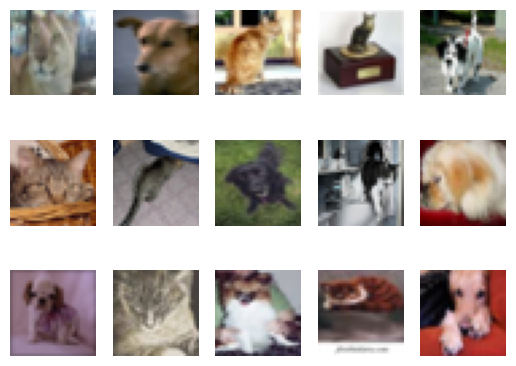

In [4]:
import matplotlib.pyplot as plt

k = 0
for images, labels in train_loader:
    # since batch_size = 1, there is only 1 image in `images`
    image = images[0]
    # place the colour channel at the end, instead of at the beginning
    img = np.transpose(image, [1,2,0])
    # normalize pixel intensity values to [0, 1]
    img = img / 2 + 0.5
    plt.subplot(3, 5, k+1)
    plt.axis('off')
    plt.imshow(img)

    k += 1
    if k > 14:
        break

### Part (b) -- 3 pt

How many training examples do we have for the combined `cat` and `dog` classes?
What about validation examples?
What about test examples?

In [7]:
training_examples = 0
validation_examples = 0
test_examples = 0
for images, labels in train_loader:
  for label in labels:
    if label == 3 or label ==5: # label index for cat and dog are 3 and 5
      training_examples +=1

print("The number of training examples we have for the cat and dog classes combined is " + str(training_examples) + ".")

for images, labels in val_loader:
  for label in labels:
    if label == 3 or label == 5:
      validation_examples += 1

print("The number of validation examples we have for the cat and dog classes combined is " + str(validation_examples) + ".")

for images, labels in test_loader:
  for label in labels:
    if label == 3 or label == 5:
      test_examples += 1

print("The number of testing examples we have for the cat and dog classes combined is " + str(test_examples) + ".")

The number of training examples we have for the cat and dog classes combined is 8000.
The number of validation examples we have for the cat and dog classes combined is 2000.
The number of testing examples we have for the cat and dog classes combined is 2000.


### Part (c) -- 3pt

Why do we need a validation set when training our model? What happens if we judge the
performance of our models using the training set loss/error instead of the validation
set loss/error?

We need a validation set when training our model to see how well our model performs on unseen data before moving on to the test set. Looking at our model's performance on the validation set (unseen dataset), we can tune the hyperparameters and prevent the overfitting of our model on the training data. If we judge the performance of our models solely on the loss/error of the training set instead of the validation set, we could risk overfitting our model to the training data. Overfitting would result in a less optimal performance/accuracy on the test set which, if the model has only been exposed to the training set, will be the first time the model looks at data it has yet to see.

## Part 2. Training [15 pt]

We define two neural networks, a `LargeNet` and `SmallNet`.
We'll be training the networks in this section.

You won't understand fully what these networks are doing until
the next few classes, and that's okay. For this assignment, please
focus on learning how to train networks, and how hyperparameters affect
training.

In [8]:
class LargeNet(nn.Module):
    def __init__(self):
        super(LargeNet, self).__init__()
        self.name = "large"
        self.conv1 = nn.Conv2d(3, 5, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(5, 10, 5)
        self.fc1 = nn.Linear(10 * 5 * 5, 32)
        self.fc2 = nn.Linear(32, 1)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 10 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        x = x.squeeze(1) # Flatten to [batch_size]
        return x

In [9]:
class SmallNet(nn.Module):
    def __init__(self):
        super(SmallNet, self).__init__()
        self.name = "small"
        self.conv = nn.Conv2d(3, 5, 3)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc = nn.Linear(5 * 7 * 7, 1)

    def forward(self, x):
        x = self.pool(F.relu(self.conv(x)))
        x = self.pool(x)
        x = x.view(-1, 5 * 7 * 7)
        x = self.fc(x)
        x = x.squeeze(1) # Flatten to [batch_size]
        return x

In [10]:
small_net = SmallNet()
large_net = LargeNet()

### Part (a) -- 2pt

The methods `small_net.parameters()` and `large_net.parameters()`
produces an iterator of all the trainable parameters of the network.
These parameters are torch tensors containing many scalar values.

We haven't learned how how the parameters in these high-dimensional
tensors will be used, but we should be able to count the number
of parameters. Measuring the number of parameters in a network is
one way of measuring the "size" of a network.

What is the total number of parameters in `small_net` and in
`large_net`? (Hint: how many numbers are in each tensor?)

In [11]:
for param in small_net.parameters():
    print(param.shape)

print("\n")

for param in large_net.parameters():
    print(param.shape)

torch.Size([5, 3, 3, 3])
torch.Size([5])
torch.Size([1, 245])
torch.Size([1])


torch.Size([5, 3, 5, 5])
torch.Size([5])
torch.Size([10, 5, 5, 5])
torch.Size([10])
torch.Size([32, 250])
torch.Size([32])
torch.Size([1, 32])
torch.Size([1])


To get the total number of parameters in small_net and large_net, we find how many numbers there are in each tensor, then add them.

---
total number of parameters in small_net = 5\*3\*3\*3 + 5 + 1\*245 + 1 = 386 <br>
total number of parameters in large_net = 5\*3\*5\*5 + 5 + 10\*5\*5\*5 + 10 + 32\*250 + 32 + 1\*32 + 1 = 9705


### The function train_net

The function `train_net` below takes an untrained neural network (like `small_net` and `large_net`) and
several other parameters. You should be able to understand how this function works.
The figure below shows the high level training loop for a machine learning model:

![alt text](https://github.com/UTNeural/Lab2/blob/master/Diagram.png?raw=true)

In [12]:
def train_net(net, batch_size=64, learning_rate=0.01, num_epochs=30):
    ########################################################################
    # Train a classifier on cats vs dogs
    target_classes = ["cat", "dog"]
    ########################################################################
    # Fixed PyTorch random seed for reproducible result
    torch.manual_seed(1000)
    ########################################################################
    # Obtain the PyTorch data loader objects to load batches of the datasets
    train_loader, val_loader, test_loader, classes = get_data_loader(
            target_classes, batch_size)
    ########################################################################
    # Define the Loss function and optimizer
    # The loss function will be Binary Cross Entropy (BCE). In this case we
    # will use the BCEWithLogitsLoss which takes unnormalized output from
    # the neural network and scalar label.
    # Optimizer will be SGD with Momentum.
    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9)
    ########################################################################
    # Set up some numpy arrays to store the training/test loss/erruracy
    train_err = np.zeros(num_epochs)
    train_loss = np.zeros(num_epochs)
    val_err = np.zeros(num_epochs)
    val_loss = np.zeros(num_epochs)
    ########################################################################
    # Train the network
    # Loop over the data iterator and sample a new batch of training data
    # Get the output from the network, and optimize our loss function.
    start_time = time.time()
    for epoch in range(num_epochs):  # loop over the dataset multiple times
        total_train_loss = 0.0
        total_train_err = 0.0
        total_epoch = 0
        for i, data in enumerate(train_loader, 0):
            # Get the inputs
            inputs, labels = data
            labels = normalize_label(labels) # Convert labels to 0/1
            # Zero the parameter gradients
            optimizer.zero_grad()
            # Forward pass, backward pass, and optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels.float())
            loss.backward()
            optimizer.step()
            # Calculate the statistics
            corr = (outputs > 0.0).squeeze().long() != labels
            total_train_err += int(corr.sum())
            total_train_loss += loss.item()
            total_epoch += len(labels)
        train_err[epoch] = float(total_train_err) / total_epoch
        train_loss[epoch] = float(total_train_loss) / (i+1)
        val_err[epoch], val_loss[epoch] = evaluate(net, val_loader, criterion)
        print(("Epoch {}: Train err: {}, Train loss: {} |"+
               "Validation err: {}, Validation loss: {}").format(
                   epoch + 1,
                   train_err[epoch],
                   train_loss[epoch],
                   val_err[epoch],
                   val_loss[epoch]))
        # Save the current model (checkpoint) to a file
        model_path = get_model_name(net.name, batch_size, learning_rate, epoch)
        torch.save(net.state_dict(), model_path)
    print('Finished Training')
    end_time = time.time()
    elapsed_time = end_time - start_time
    print("Total time elapsed: {:.2f} seconds".format(elapsed_time))
    # Write the train/test loss/err into CSV file for plotting later
    epochs = np.arange(1, num_epochs + 1)
    np.savetxt("{}_train_err.csv".format(model_path), train_err)
    np.savetxt("{}_train_loss.csv".format(model_path), train_loss)
    np.savetxt("{}_val_err.csv".format(model_path), val_err)
    np.savetxt("{}_val_loss.csv".format(model_path), val_loss)

### Part (b) -- 1pt

The parameters to the function `train_net` are hyperparameters of our neural network.
We made these hyperparameters easy to modify so that we can tune them later on.

What are the default values of the parameters `batch_size`, `learning_rate`,
and `num_epochs`?

The default values of the parameters batch_size, learning_rate, and num_epochs are 64, 0.01, and 30 respectively.

### Part (c) -- 3 pt

What files are written to disk when we call `train_net` with `small_net`, and train for 5 epochs? Provide a list
of all the files written to disk, and what information the files contain.



*   After each epoch (in this case 5 epochs), the current model (checkpoint) containing the model name and values for the batch size, learning rate, and epoch will be saved to a file.
*   A file ({}_train_err.csv) containing the training error values will be written to the disk
*   A file ({}_train_loss.csv) containing the training loss values will be written to the disk
*   A file ({}_val_err.csv) containing the validation error values will be written to the disk
*   A file ({}_val_loss.csv) containing the validation loss values will be written to the disk




### Part (d) -- 2pt

Train both `small_net` and `large_net` using the function `train_net` and its default parameters.
The function will write many files to disk, including a model checkpoint (saved values of model weights)
at the end of each epoch.

If you are using Google Colab, you will need to mount Google Drive
so that the files generated by `train_net` gets saved. We will be using
these files in part (d).
(See the Google Colab tutorial for more information about this.)

Report the total time elapsed when training each network. Which network took longer to train?
Why?

In [13]:
# Since the function writes files to disk, you will need to mount
# your Google Drive. If you are working on the lab locally, you
# can comment out this code.

from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [14]:
train_net(small_net, 64, 0.01, 30)
train_net(large_net, 64, 0.01, 30)

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.439125, Train loss: 0.6794547924995422 |Validation err: 0.3705, Validation loss: 0.6556404661387205
Epoch 2: Train err: 0.367875, Train loss: 0.6456690139770508 |Validation err: 0.3715, Validation loss: 0.6579459458589554
Epoch 3: Train err: 0.347, Train loss: 0.6265002403259278 |Validation err: 0.339, Validation loss: 0.6200802344828844
Epoch 4: Train err: 0.33325, Train loss: 0.6110910873413086 |Validation err: 0.357, Validation loss: 0.6265374030917883
Epoch 5: Train err: 0.32425, Train loss: 0.6025455060005188 |Validation err: 0.332, Validation loss: 0.6140771489590406
Epoch 6: Train err: 0.313375, Train loss: 0.5928082098960876 |Validation err: 0.332, Validation loss: 0.6122098341584206
Epoch 7: Train err: 0.311375, Train loss: 0.5892952492237091 |Validation err: 0.327, Validation loss: 0.6012027375400066
Epoch 8: Train err: 0.308, Train loss: 0.5821820387840271 |Validation err: 0.315

Total time elapsed for small_net: 149.80 seconds <br>
Total time elapsed for large_net: 170.62 seconds <br>
large_net took longer to train. This is because large_net has more layers and thus more parameters to train than small_net.

### Part (e) - 2pt

Use the function `plot_training_curve` to display the trajectory of the
training/validation error and the training/validation loss.
You will need to use the function `get_model_name` to generate the
argument to the `plot_training_curve` function.

Do this for both the small network and the large network. Include both plots
in your writeup.

small_net


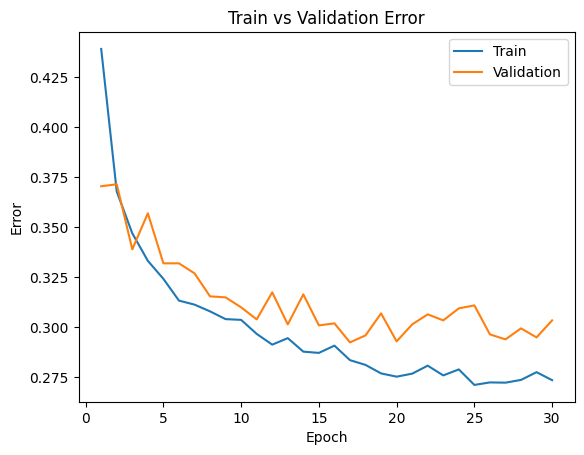

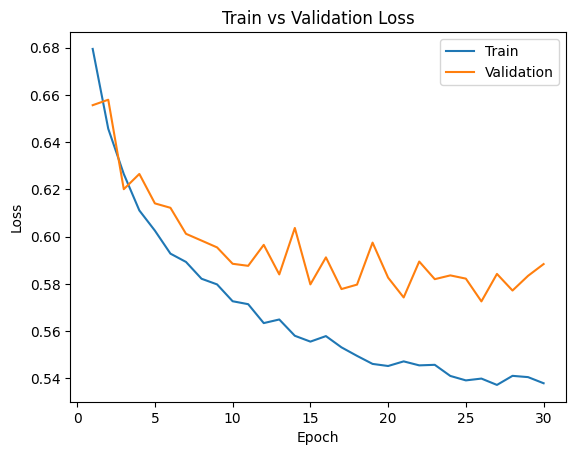


large_net


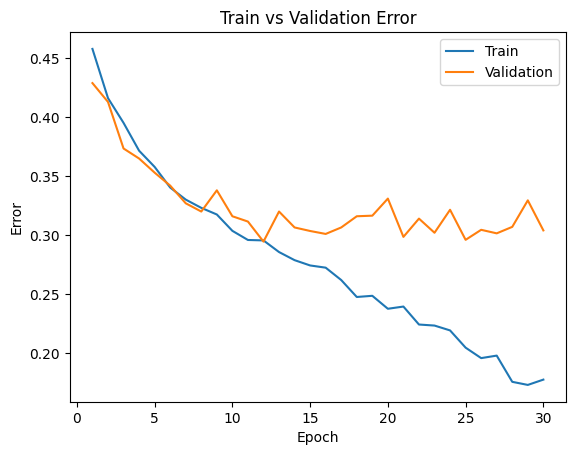

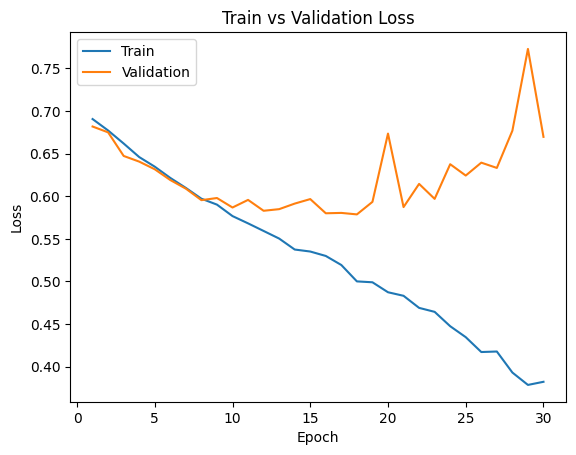

In [16]:
small_net_model_path = get_model_name("small", batch_size=64, learning_rate=0.01, epoch=29)
large_net_model_path = get_model_name("large", batch_size=64, learning_rate=0.01, epoch=29)
print("small_net")
plot_training_curve(small_net_model_path)
print("\nlarge_net")
plot_training_curve(large_net_model_path)

### Part (f) - 5pt

Describe what you notice about the training curve.
How do the curves differ for `small_net` and `large_net`?
Identify any occurences of underfitting and overfitting.

The training curves for both small_net and large_net have a downwards/decreasing trend. Comparing the curves for small_net and large_net, the training curves for small_net seem to be flattening out and starting to converge to a certain value, whereas for large_net the training curves are still decreasing consistently at 30 epochs. In terms of the validation curves, both networks have a much more obvious fluctuation. The validation curves for small_net show less sign of overfitting compared to large_net. Specifically in the large_net training and validation loss, we can see that the validation curve starts increases after 15 epochs, showing that the model is overfit and can't generalize to other images because it has learned the training data too well.

## Part 3. Optimization Parameters [12 pt]

For this section, we will work with `large_net` only.

### Part (a) - 3pt

Train `large_net` with all default parameters, except set `learning_rate=0.001`.
Does the model take longer/shorter to train?
Plot the training curve. Describe the effect of *lowering* the learning rate.

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.47625, Train loss: 0.6928360004425049 |Validation err: 0.467, Validation loss: 0.6924686580896378
Epoch 2: Train err: 0.448625, Train loss: 0.6922589740753173 |Validation err: 0.4305, Validation loss: 0.6916493494063616
Epoch 3: Train err: 0.43575, Train loss: 0.6916067256927491 |Validation err: 0.4285, Validation loss: 0.6908544301986694
Epoch 4: Train err: 0.43, Train loss: 0.6908613419532776 |Validation err: 0.424, Validation loss: 0.6896595824509859
Epoch 5: Train err: 0.434125, Train loss: 0.6899194955825806 |Validation err: 0.4195, Validation loss: 0.6886935662478209
Epoch 6: Train err: 0.43575, Train loss: 0.688741192817688 |Validation err: 0.4195, Validation loss: 0.6867824867367744
Epoch 7: Train err: 0.437125, Train loss: 0.6873774199485779 |Validation err: 0.4185, Validation loss: 0.6851983051747084
Epoch 8: Train err: 0.4375, Train loss: 0.6859278454780579 |Validation err: 0.41

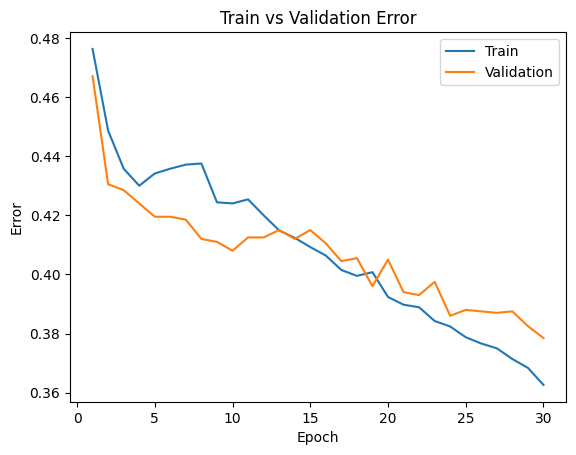

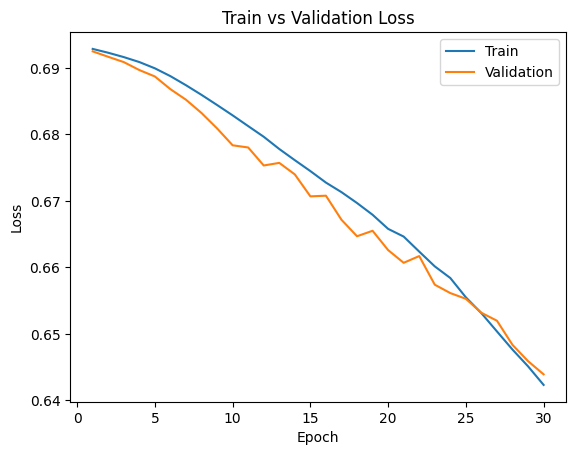

In [17]:
# Note: When we re-construct the model, we start the training
# with *random weights*. If we omit this code, the values of
# the weights will still be the previously trained values.
large_net = LargeNet()
train_net(large_net, learning_rate = 0.001)
large_net_model_path = get_model_name("large", batch_size=64, learning_rate=0.001, epoch=29)
plot_training_curve(large_net_model_path)

This model takes longer than the previous model to train. Lowering the learning rate caused the validation error and loss to follow a downwards/decreasing trend similar to the training error and loss. The model has much less fluctuation and is not overfitted to the training data like it was with the previous model with the higher learning rate. This is because the model is learning slower/taking smaller steps, allowing it to be more stable and possibly make better adjustments to the weights so that it can generalize the validation data better than before. However, it seems lowering the learning rate also caused the model to be underfit as the training and validation loss and error are both decreasing/haven't converged yet.

### Part (b) - 3pt

Train `large_net` with all default parameters, except set `learning_rate=0.1`.
Does the model take longer/shorter to train?
Plot the training curve. Describe the effect of *increasing* the learning rate.

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.4295, Train loss: 0.6743778004646301 |Validation err: 0.3595, Validation loss: 0.6350856963545084
Epoch 2: Train err: 0.36075, Train loss: 0.6411805462837219 |Validation err: 0.3535, Validation loss: 0.6361209936439991
Epoch 3: Train err: 0.365125, Train loss: 0.6321813464164734 |Validation err: 0.3385, Validation loss: 0.6056603863835335
Epoch 4: Train err: 0.352625, Train loss: 0.623345623254776 |Validation err: 0.3575, Validation loss: 0.6362800160422921
Epoch 5: Train err: 0.34075, Train loss: 0.610801386833191 |Validation err: 0.3305, Validation loss: 0.6064918749034405
Epoch 6: Train err: 0.323375, Train loss: 0.5921835992336273 |Validation err: 0.317, Validation loss: 0.5967769687995315
Epoch 7: Train err: 0.3145, Train loss: 0.5817317562103271 |Validation err: 0.3365, Validation loss: 0.6204487904906273
Epoch 8: Train err: 0.29825, Train loss: 0.5660300071239471 |Validation err: 0.

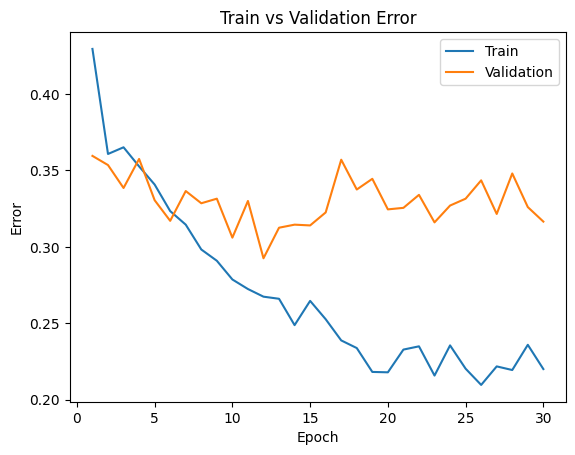

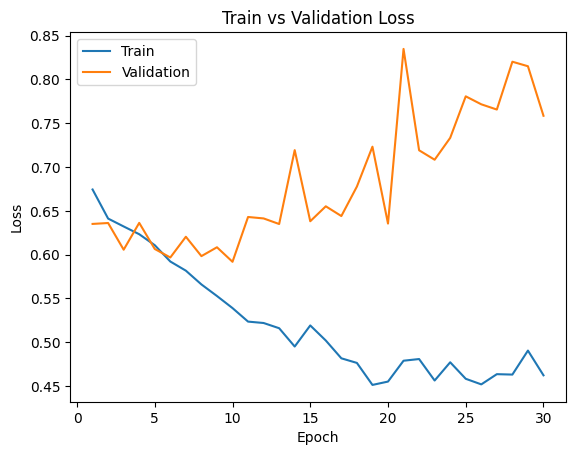

In [18]:
large_net = LargeNet()
train_net(large_net, learning_rate = 0.1)
large_net_model_path = get_model_name("large", batch_size=64, learning_rate=0.1, epoch=29)
plot_training_curve(large_net_model_path)

This model takes a shorter amount of time to train in comparison to the lower learning rate. Increasing the learing rate caused much more fluctuation/instability in the training and validation error and loss. It also caused the validation loss to start increasing, thus overfitting the model to the training data earlier than the previous models (around 10 epochs instead of 15).

### Part (c) - 3pt

Train `large_net` with all default parameters, including with `learning_rate=0.01`.
Now, set `batch_size=512`. Does the model take longer/shorter to train?
Plot the training curve. Describe the effect of *increasing* the batch size.

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.48175, Train loss: 0.6929379552602768 |Validation err: 0.478, Validation loss: 0.6926824003458023
Epoch 2: Train err: 0.457625, Train loss: 0.6924104057252407 |Validation err: 0.434, Validation loss: 0.6917425245046616
Epoch 3: Train err: 0.437, Train loss: 0.6916500627994537 |Validation err: 0.4265, Validation loss: 0.6909129917621613
Epoch 4: Train err: 0.433625, Train loss: 0.6908449903130531 |Validation err: 0.424, Validation loss: 0.6897870302200317
Epoch 5: Train err: 0.434, Train loss: 0.6896935515105724 |Validation err: 0.424, Validation loss: 0.6881355047225952
Epoch 6: Train err: 0.438, Train loss: 0.6883532106876373 |Validation err: 0.4285, Validation loss: 0.686011865735054
Epoch 7: Train err: 0.439375, Train loss: 0.6866871751844883 |Validation err: 0.426, Validation loss: 0.6836968660354614
Epoch 8: Train err: 0.43525, Train loss: 0.6849770732223988 |Validation err: 0.4115, V

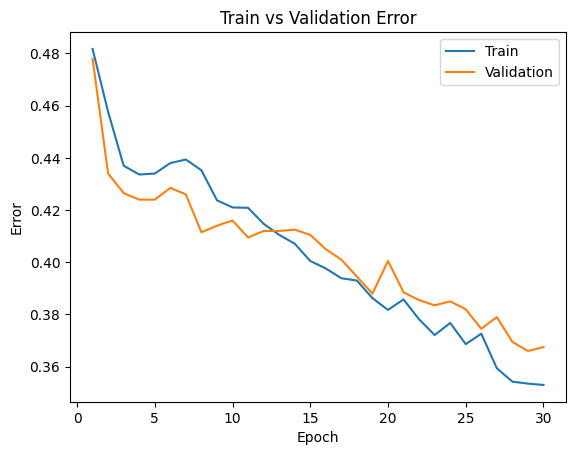

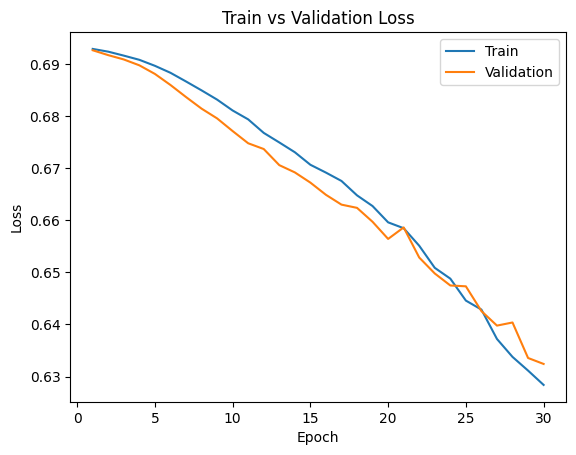

In [19]:
large_net = LargeNet()
train_net(large_net, batch_size = 512)
large_net_model_path = get_model_name("large", batch_size=512, learning_rate=0.01, epoch=29)
plot_training_curve(large_net_model_path)

The model takes a shorter amount of time to train. Increasing the batch size resulted in a smoother downward trend in the validation error and loss that follows the training error and loss more closely. The model also isn't overfitting to the training data like it did previously, however it seems to have caused the model to be underfit as the validation and training loss are both decreasing at 30 epochs still. This is most likely because the model takes in more data with each training pass, so it has to learn from a wider range of images which makes it more difficult to catch smaller details in the data (the model will take longer/more epochs to converge).

### Part (d) - 3pt

Train `large_net` with all default parameters, including with `learning_rate=0.01`.
Now, set `batch_size=16`. Does the model take longer/shorter to train?
Plot the training curve. Describe the effect of *decreasing* the batch size.

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.43175, Train loss: 0.6774994033575058 |Validation err: 0.382, Validation loss: 0.6513170146942139
Epoch 2: Train err: 0.369, Train loss: 0.6396398993134499 |Validation err: 0.3465, Validation loss: 0.6161113579273224
Epoch 3: Train err: 0.34375, Train loss: 0.6098222960829734 |Validation err: 0.3325, Validation loss: 0.6260210766792297
Epoch 4: Train err: 0.314375, Train loss: 0.584969149172306 |Validation err: 0.34, Validation loss: 0.6044013905525207
Epoch 5: Train err: 0.301125, Train loss: 0.5689119317531586 |Validation err: 0.3125, Validation loss: 0.5769183149337769
Epoch 6: Train err: 0.281, Train loss: 0.5452213580608368 |Validation err: 0.308, Validation loss: 0.570844743013382
Epoch 7: Train err: 0.270875, Train loss: 0.5272981309890747 |Validation err: 0.307, Validation loss: 0.5854293291568756
Epoch 8: Train err: 0.259375, Train loss: 0.507090549826622 |Validation err: 0.313, V

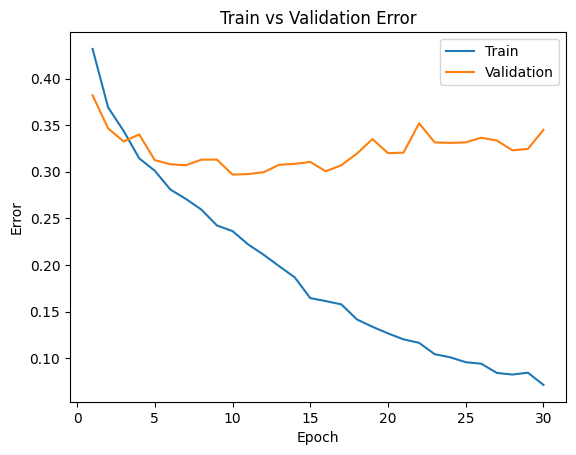

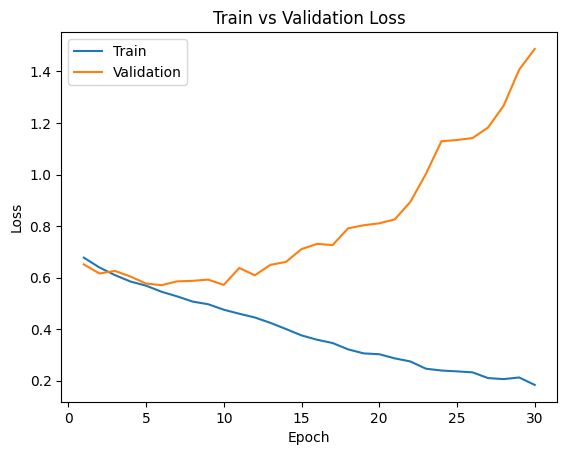

In [20]:
large_net = LargeNet()
train_net(large_net, batch_size = 16)
large_net_model_path = get_model_name("large", batch_size=16, learning_rate=0.01, epoch=29)
plot_training_curve(large_net_model_path)

The model takes longer to train. Decreasing the batch size caused the model to overfit to the training data, this can be seen in the increase in the validation curves at around 10 epochs. Due to the smaller batch size, the model takes in less data for each training iteration, meaning it can learn the training data more closely and catch smaller details. Since the model is learning the smaller nuances in the training set, it cannot generalize to the validation data well.

## Part 4. Hyperparameter Search [6 pt]

### Part (a) - 2pt

Based on the plots from above, choose another set of values for the hyperparameters (network, batch_size, learning_rate)
that you think would help you improve the validation accuracy. Justify your choice.

Based on the plots from above, I will keep the batch_size of 512 and learning_rate of 0.01 as those hyperparameters didn't cause the model to be overfit to the training data. However, since the training and validation error and loss were both still decreasing for that model, I will increase the number of epochs from 30 to 64 so that the model can learn from the training set more thorougly which will hopefully stop the model from being underfit.

### Part (b) - 1pt

Train the model with the hyperparameters you chose in part(a), and include the training curve.

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.48175, Train loss: 0.6929379552602768 |Validation err: 0.478, Validation loss: 0.6926824003458023
Epoch 2: Train err: 0.457625, Train loss: 0.6924104057252407 |Validation err: 0.434, Validation loss: 0.6917425245046616
Epoch 3: Train err: 0.437, Train loss: 0.6916500627994537 |Validation err: 0.4265, Validation loss: 0.6909129917621613
Epoch 4: Train err: 0.433625, Train loss: 0.6908449903130531 |Validation err: 0.424, Validation loss: 0.6897870302200317
Epoch 5: Train err: 0.434, Train loss: 0.6896935515105724 |Validation err: 0.424, Validation loss: 0.6881355047225952
Epoch 6: Train err: 0.438, Train loss: 0.6883532106876373 |Validation err: 0.4285, Validation loss: 0.686011865735054
Epoch 7: Train err: 0.439375, Train loss: 0.6866871751844883 |Validation err: 0.426, Validation loss: 0.6836968660354614
Epoch 8: Train err: 0.43525, Train loss: 0.6849770732223988 |Validation err: 0.4115, V

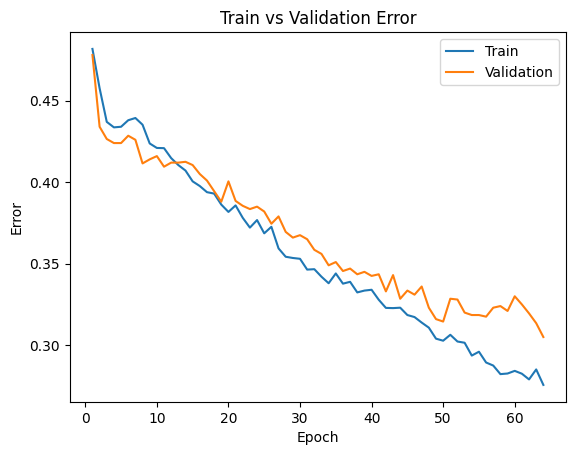

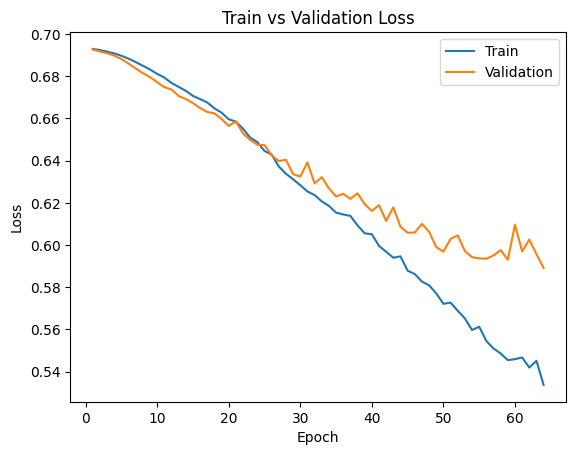

In [21]:
large_net = LargeNet()
train_net(large_net, batch_size = 512, learning_rate = 0.01, num_epochs = 64)
large_net_model_path = get_model_name("large", batch_size=512, learning_rate=0.01, epoch=63)
plot_training_curve(large_net_model_path)

### Part (c) - 2pt

Based on your result from Part(a), suggest another set of hyperparameter values to try.
Justify your choice.

The training and validation error and loss curves are still both decreasing and haven't converged, so I will keep the batch size the same and try increasing the number of epochs from 64 to 128. This will hopefully make the curves converge or at least get them to a slope closer to zero. The validation curves are also fluctuating more, so we can try lowering the learning rate from 0.01 to 0.007 because previously lowering the learning rate caused the curves to be more stable.

### Part (d) - 1pt

Train the model with the hyperparameters you chose in part(c), and include the training curve.

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.49775, Train loss: 0.6934526674449444 |Validation err: 0.509, Validation loss: 0.6940379738807678
Epoch 2: Train err: 0.497375, Train loss: 0.6930113844573498 |Validation err: 0.5095, Validation loss: 0.6933044642210007
Epoch 3: Train err: 0.496, Train loss: 0.692648246884346 |Validation err: 0.502, Validation loss: 0.6928607523441315
Epoch 4: Train err: 0.48975, Train loss: 0.6923941224813461 |Validation err: 0.49, Validation loss: 0.6925099343061447
Epoch 5: Train err: 0.472125, Train loss: 0.6920757628977299 |Validation err: 0.467, Validation loss: 0.6920370757579803
Epoch 6: Train err: 0.4495, Train loss: 0.6917869225144386 |Validation err: 0.452, Validation loss: 0.6916003823280334
Epoch 7: Train err: 0.444375, Train loss: 0.6914237476885319 |Validation err: 0.4405, Validation loss: 0.6910627037286758
Epoch 8: Train err: 0.43525, Train loss: 0.6909911595284939 |Validation err: 0.4305,

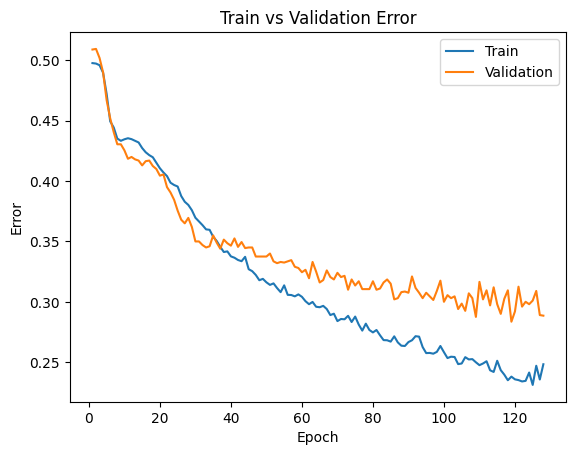

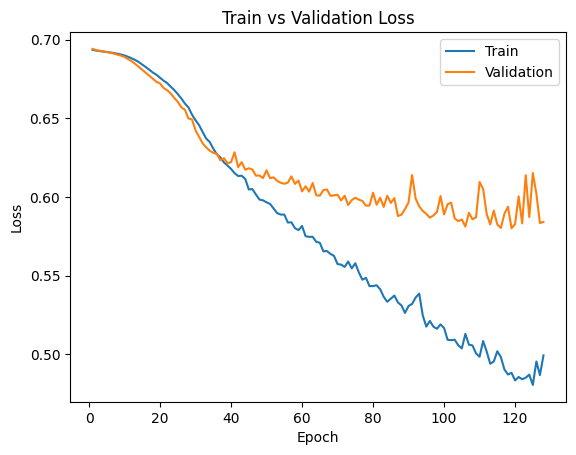

In [26]:
large_net = LargeNet()
train_net(large_net, batch_size = 512, learning_rate = 0.007, num_epochs = 128)
large_net_model_path = get_model_name("large", batch_size=512, learning_rate=0.007, epoch=127)
plot_training_curve(large_net_model_path)

## Part 4. Evaluating the Best Model [15 pt]


### Part (a) - 1pt

Choose the **best** model that you have so far. This means choosing the best model checkpoint,
including the choice of `small_net` vs `large_net`, the `batch_size`, `learning_rate`,
**and the epoch number**.

Modify the code below to load your chosen set of weights to the model object `net`.

In [27]:
net = LargeNet()
model_path = get_model_name(net.name, batch_size=512, learning_rate=0.007, epoch=127)
state = torch.load(model_path)
net.load_state_dict(state)

<All keys matched successfully>

### Part (b) - 2pt

Justify your choice of model from part (a).

I chose the second model I trained from the previous section of the lab because it gave the lowest validation error and loss. It also was not overfitting to the training data, and the curves were starting to converge. However, if I were to try to improve the model, I might try a lower batch size because it looks like the training curves are still decreasing despite the validation curves starting to converge. I think lowering the batch size will allow the model to catch smaller nuances/details in the data and cause the training curves to converge more than they are as of now.

### Part (c) - 2pt

Using the code in Part 0, any code from lecture notes, or any code that you write,
compute and report the **test classification error** for your chosen model.

In [29]:
# If you use the `evaluate` function provided in part 0, you will need to
# set batch_size > 1
train_loader, val_loader, test_loader, classes = get_data_loader(
    target_classes=["cat", "dog"],
    batch_size=512)
criterion = nn.BCEWithLogitsLoss()
test_err, test_loss = evaluate(net, test_loader, criterion)
print("Test error: {}, Test loss: {}".format(test_err, test_loss))
print("The test classification error is ", test_err)

Files already downloaded and verified
Files already downloaded and verified
Test error: 0.277, Test loss: 0.5431777685880661
The test classification error is  0.277


### Part (d) - 3pt

How does the test classification error compare with the **validation error**?
Explain why you would expect the test error to be *higher* than the validation error.

The test classification error for the chosen model was 0.277 and the validation error was 0.2885. I would expect the test error to be higher than the validation error because the test data hasn't been seen by the model yet (this is the first time), whereas we have already modified the parameters to better fit the validation data a couple of times. However, since the model gave a lower test error than validation error, it leads me to think that maybe the test set is more similar to the training set than the validation set is, therefore causing the model to have a better performance on the testing data.

### Part (e) - 2pt

Why did we only use the test data set at the very end?
Why is it important that we use the test data as little as possible?

We only used the test dataset at the very end because it allows us to check how our model will perform on unseen data. We should use the test data as little as possible because we don't want the model to be memorizing the answers rather than learning from the patterns and how to generalize those patterns on unseen data. This is also why having a validation dataset is important, as it acts as a way to almost pre-test our model on more strange/less common data before moving to the actual test data which will give us an idea on how the model will perform when it's being used in the real world.

### Part (f) - 5pt

How does the your best CNN model compare with an 2-layer ANN model (no convolutional layers) on classifying cat and dog images. You can use a 2-layer ANN architecture similar to what you used in Lab 1. You should explore different hyperparameter settings to determine how well you can do on the validation dataset. Once satisified with the performance, you may test it out on the test data.

Hint: The ANN in lab 1 was applied on greyscale images. The cat and dog images are colour (RGB) and so you will need to flatted and concatinate all three colour layers before feeding them into an ANN.

In [40]:
class ANN(nn.Module):
    def __init__(self):
        super(ANN, self).__init__()
        self.name = "ANN"
        self.layer1 = nn.Linear(3 *32 * 32, 64)
        self.layer2 = nn.Linear(64, 1)
    def forward(self, img):
        flattened = img.view(-1, 3* 32 * 32)
        activation1 = self.layer1(flattened)
        activation1 = F.relu(activation1)
        activation2 = self.layer2(activation1)
        activation2 = activation2.squeeze(1)
        return activation2

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.503625, Train loss: 0.6948934227228165 |Validation err: 0.4815, Validation loss: 0.6920317888259888
Epoch 2: Train err: 0.469375, Train loss: 0.6897507935762406 |Validation err: 0.4465, Validation loss: 0.687404453754425
Epoch 3: Train err: 0.444125, Train loss: 0.684986811876297 |Validation err: 0.4375, Validation loss: 0.683685052394867
Epoch 4: Train err: 0.423, Train loss: 0.6811319380998612 |Validation err: 0.4325, Validation loss: 0.6806114792823792
Epoch 5: Train err: 0.41675, Train loss: 0.6779498517513275 |Validation err: 0.4245, Validation loss: 0.6781465172767639
Epoch 6: Train err: 0.40925, Train loss: 0.675284007191658 |Validation err: 0.428, Validation loss: 0.676002049446106
Epoch 7: Train err: 0.40775, Train loss: 0.6730301737785339 |Validation err: 0.4255, Validation loss: 0.6742218613624573
Epoch 8: Train err: 0.404875, Train loss: 0.6711025595664978 |Validation err: 0.42

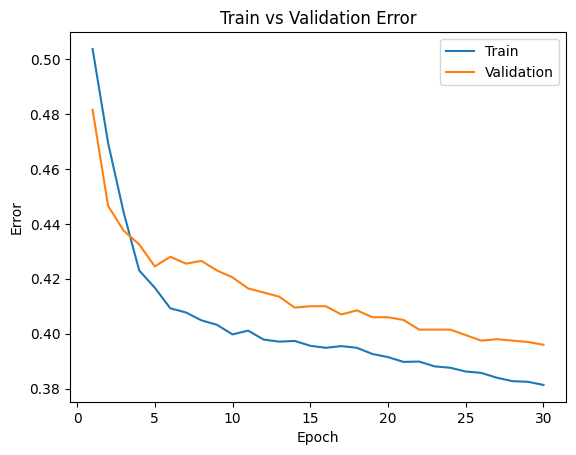

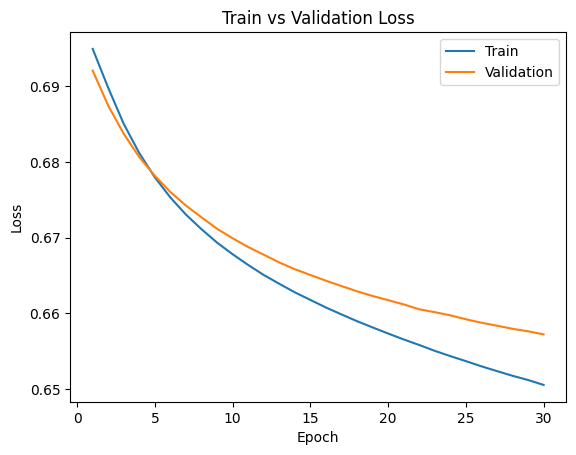

In [53]:
ANN_model = ANN()
train_net(ANN_model, batch_size = 400, learning_rate = 0.0005, num_epochs = 30)
ANN_model_path = get_model_name("ANN", batch_size=400, learning_rate=0.0005, epoch=29)
plot_training_curve(ANN_model_path)

In [54]:
train_loader, val_loader, test_loader, classes = get_data_loader(
    target_classes=["cat", "dog"],
    batch_size=400)
criterion = nn.BCEWithLogitsLoss()
test_err, test_loss = evaluate(ANN_model, test_loader, criterion)
print("Test error: {}, Test loss: {}".format(test_err, test_loss))
print("The test classification error is ", test_err)

Files already downloaded and verified
Files already downloaded and verified
Test error: 0.388, Test loss: 0.6510995268821717
The test classification error is  0.388


In comparison to the CNN, the ANN test error and loss are higher, meaning the ANN architecture does not perform as well as the CNN architecture with this particular dataset (images rather than numerical data). I tried multiple different parameters, but I was around 39% error and 65% loss for the validation set each time, whereas for the CNN I could get to a 28% error and 58% loss for the validation set.